In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import torch
import copy
from NNet import NNet

from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler

import generators as gen
import optimize as opt
import helpers as hel

%load_ext autoreload
%autoreload 2

import os


# Filter learning on SBM
Create stochastic block model with 30 nodes

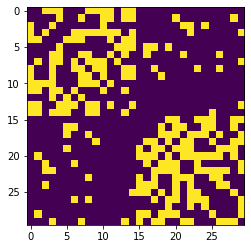

In [2]:
L = gen.generate_L_sbm(30, p_in=.5)
plt.imshow(L<0);

Filter matrix with high-pass kernel to see what happens.

In [3]:
L_hp = gen.filter_matrix(torch.Tensor(L), gen.kernel_normal)

In [4]:
A_hp = np.zeros_like(L_hp)
A_hp[L_hp<0] = -L_hp[L_hp<0]

In [5]:
L_hp.sum(axis=0)

tensor([ 1.0617e-07,  4.2841e-08, -6.5193e-08,  5.2154e-08,  5.0291e-08,
        -1.2666e-07, -5.9605e-08,  2.1048e-07,  2.4214e-07,  2.6636e-07,
         1.1362e-07,  8.7544e-08, -7.0781e-08,  1.6764e-08,  5.9605e-08,
        -1.4622e-07, -2.0489e-08,  4.0978e-08, -9.2201e-08, -1.9185e-07,
        -2.8871e-08,  1.4435e-07, -2.0955e-07, -1.7509e-07, -2.4214e-08,
         3.6322e-08, -7.7300e-08,  8.8476e-08, -2.3656e-07, -8.9407e-08])

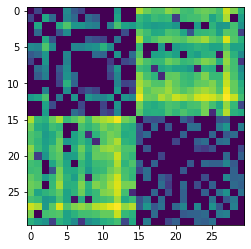

In [6]:
plt.imshow(A_hp);

Create white noise, filter it with the normal kernel on the graph topology.

In [7]:
def plot_fit_filter(L, ker, fit):
    """
    Plots a fitted kernel, as well as the true values at the position
    of the eigenvalues
    """
    evals, _ = np.linalg.eig(L)
    x = torch.Tensor(np.linspace(0.01,evals.max()+1, num=100)).unsqueeze_(-1)
    plt.plot(x.numpy(), fit(x).detach().numpy())
    plt.plot(evals, ker(torch.Tensor(evals)), 'ro')
    plt.legend(['Fitted', 'True'])
    plt.xlabel('Eigenvalue')
    plt.ylabel('Kernel');


def generate_and_fit(L, ker, n_samples=100, do_plot=True, do_return=False, 
                     **kwargs):
    """
    Generates samples from kernel, fits nnet to the resulting covariance
    matrix. 
    """
    samples = gen.gen_and_filter(L, 500, ker=ker)
    fit = opt.fit_filter(torch.Tensor(L), hel.symsqrt(torch.Tensor(np.cov(samples.T))), 
                         **kwargs)
    
    if do_plot:
        plot_fit_filter(L, ker, fit)
    if do_return:
        return samples, fit

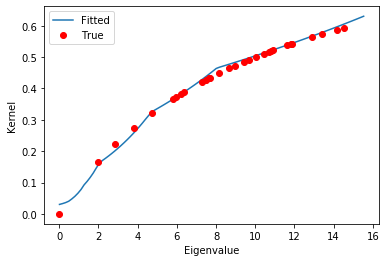

In [8]:
generate_and_fit(L, gen.kernel_highpass, n_iters=5000, lr_nnet=.01)

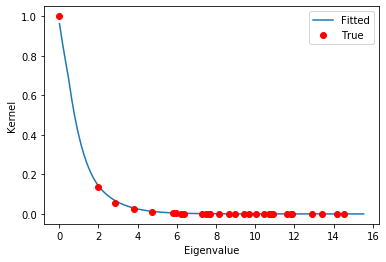

In [9]:
generate_and_fit(L, gen.kernel_heat, lr_nnet=.01)

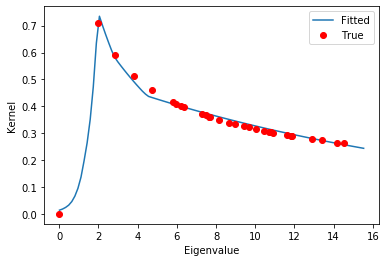

In [10]:
generate_and_fit(L, gen.kernel_normal, n_iters=5000, lr_nnet=.01)

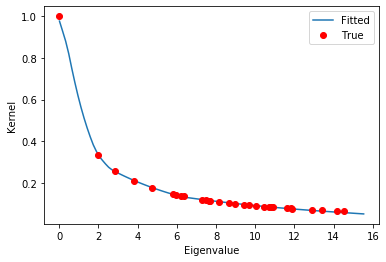

In [11]:
generate_and_fit(L, gen.kernel_tikhonov, n_iters=5000, lr_nnet=.01)

# Filter learning on a larger graph
Create stochastic block model with 100 nodes

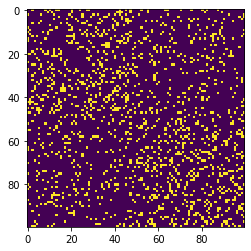

In [12]:
L_large = gen.generate_L_sbm(100, p_in=.2)
plt.imshow(L_large<0);

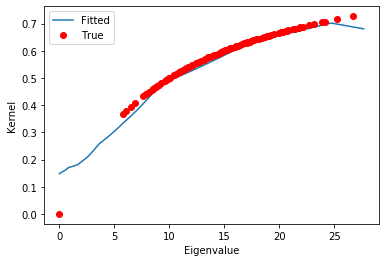

In [13]:
generate_and_fit(L_large, gen.kernel_highpass, n_iters=5000, lr_nnet=.001)

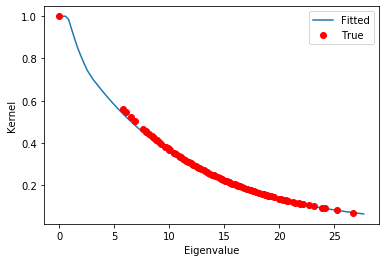

In [14]:
generate_and_fit(L_large, lambda x: gen.kernel_heat(x, alpha=.1), n_iters=100)

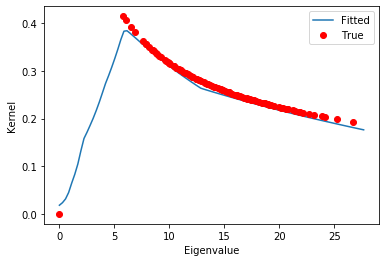

In [15]:
generate_and_fit(L_large, gen.kernel_normal, n_iters=10000, lr_nnet=.005)

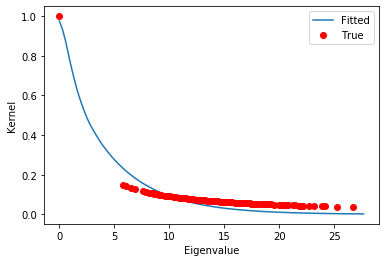

In [16]:
generate_and_fit(L_large, gen.kernel_tikhonov, n_iters=10000)

# The Learning

In [17]:
def show_learning(L, ker, nit_tot, n_curves, **kwargs):
    evals, _ = np.linalg.eig(L)
    x = torch.Tensor(np.linspace(0.01,evals.max()+1, num=100)).unsqueeze_(-1)

    h = NNet()
    samples = gen.gen_and_filter(L, 500, ker=ker)
    
    for i in range(n_curves):
        h = opt.fit_filter(torch.Tensor(L), hel.symsqrt(torch.Tensor(np.cov(samples.T))), 
                           h=h, n_iters=int(nit_tot/n_curves), **kwargs)
        plt.plot(x, h(x).detach().numpy())
    
    plt.plot(evals, ker(torch.Tensor(evals)), 'ro')
    plt.legend([str(int(nit_tot/n_curves*(i+1))) + ' Epochs' for i in range(n_curves)] +
               ['Truth'])
    plt.xlabel('Eigenvalue')
    plt.ylabel('Kernel')
    


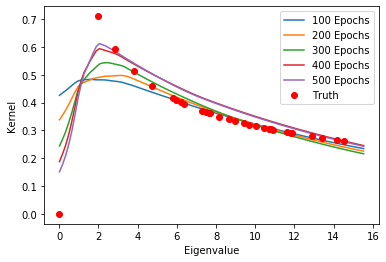

In [18]:
show_learning(L, gen.kernel_normal, 500, 5, lr_nnet=.01)